# Fully Connected Dense Neural Network

Samples:  5038 630 630
Batch:  158 20 20
Batch shapes: torch.Size([32, 4096]), torch.Size([32, 1024])


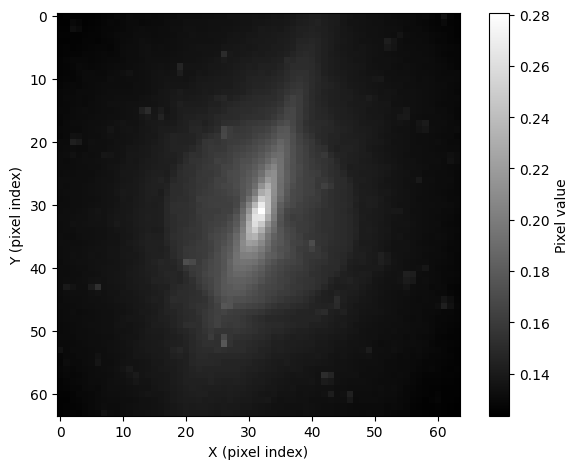

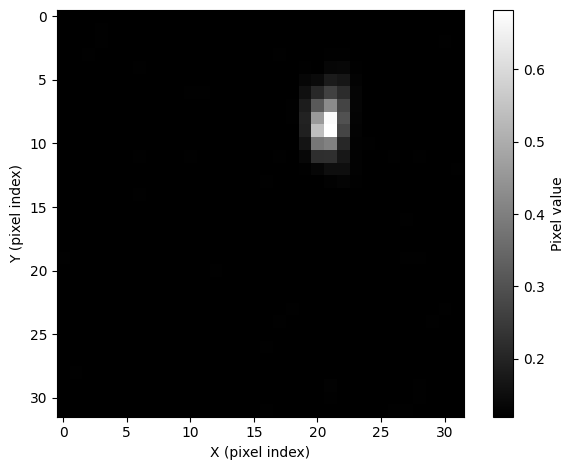

Detected framework: PyTorch
Framework:           PyTorch
Model:               SHLNeuralNetwork
Device / dtype:      unavailable / N/A
Parameters:          20,976,640 total
                     20,976,640 trainable
                     0 non-trainable
Size:                80.02 MB
Sub-modules:         4


In [1]:
# pip install xflow-py
from xflow import ConfigManager, FileProvider, PyTorchPipeline, show_model_info
from xflow.data import build_transforms_from_config
from xflow.utils import load_validated_config, plot_image

from SHL_DNN import SHLNeuralNetwork
from config_utils import load_config
import torch

# Configuration
config_manager = ConfigManager(load_config("SHL_DNN.yaml"))
config = config_manager.get()
config_manager.add_files(config["extra_files"])

# ==================== 
# Prepare Dataset
# ====================
provider = FileProvider(config["paths"]["datasets"]["mmf"]).subsample(fraction=config["data"]["subsample_fraction"], seed=config["seed"])
train_provider, temp_provider = provider.split(ratio=config["data"]["train_val_split"], seed=config["seed"])
val_provider, test_provider = temp_provider.split(ratio=config["data"]["val_test_split"], seed=config["seed"])
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])

def make_dataset(provider):
    return PyTorchPipeline(provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

train_dataset = make_dataset(train_provider)
val_dataset = make_dataset(val_provider)
test_dataset = make_dataset(test_provider)

print("Samples: ",len(train_provider),len(val_provider),len(test_provider))
print("Batch: ",len(train_dataset),len(val_dataset),len(test_dataset))

for left_parts, right_parts in test_dataset:
    # batch will be a tuple: (right_halves, left_halves) due to split_width
    print(f"Batch shapes: {left_parts.shape}, {right_parts.shape}")
    plot_image(left_parts[0].reshape(config['data']['input_image_size']))
    plot_image(right_parts[0].reshape(config['data']['output_size']))
    break

# ==================== 
# Construct Model
# ====================
model = SHLNeuralNetwork(
    input_size=config['data']['input_image_size'][0] * config['data']['input_image_size'][1],
    hidden_size=config['model']['hidden_size'], 
    output_size=config['data']['output_size'][0] * config['data']['output_size'][1],
    dropout_rate=config['model']['dropout_rate']
)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

show_model_info(model)

In [2]:
from utils import make_beam_param_metric
from functools import partial

import xflow.extensions.physics
from xflow.trainers import TorchTrainer, build_callbacks_from_config
from xflow.extensions.physics.beam import extract_beam_parameters

criterion = torch.nn.MSELoss()   # torch.nn.MSELoss()  torch.nn.L1Loss()   torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['learning_rate'])

# 2) callbacks (unchanged) + any custom wiring
callbacks = build_callbacks_from_config(
    config=config["callbacks"],
    framework=config["framework"],   
)
callbacks[-1].set_dataset(test_dataset)  # keep dataset closure

# Extract beam parameters
def extract_beam_parameters_flat(flat_img, **kwargs):
    """
    Adapter for extract_beam_parameters to handle flattened square images.
    Supports both NumPy arrays and PyTorch tensors.
    """
    import numpy as np
    # Get total number of elements robustly
    if hasattr(flat_img, "numel"):
        n = flat_img.numel()
    elif hasattr(flat_img, "size"):
        n = flat_img.size
    else:
        n = len(flat_img)
    side = int(np.sqrt(n))
    img = flat_img.reshape((side, side))
    return extract_beam_parameters(img, **kwargs)

extract_beam_parameters_dict = partial(extract_beam_parameters_flat, as_array=False)
beam_param_metric = make_beam_param_metric(extract_beam_parameters_dict)

# 3) run training
trainer = TorchTrainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    callbacks=callbacks,
    output_dir=config["paths"]["output"],
    data_pipeline=train_dataset,
    val_metrics=[beam_param_metric]
)

history = trainer.fit(
    train_loader=train_dataset, 
    val_loader=val_dataset,
    epochs=config['training']['epochs'],
)

# 4) persist
trainer.save_history(f"{config['paths']['output']}/history.json")
trainer.save_model(config["paths"]["output"])  # uses model.save_model(...) if available
config_manager.save(output_dir=config["paths"]["output"], config_filename=config["name"])

Starting Training
Total epochs: 100

Epoch 1/100 - 158 batches
input image max pixel: 0.3522, ground truth image max pixel: 0.4983, reconstructed image max pixel: 0.5394
[==============================] 158/158 (100.0%) - ETA: 0s - train_loss: 0.0093 - val_loss: 0.0025                    
Epoch 1 completed in 109.49s - train_loss: 0.0093 - val_loss: 0.0025

Epoch 2/100 - 158 batches
input image max pixel: 0.4659, ground truth image max pixel: 0.6395, reconstructed image max pixel: 0.1167
[==============================] 158/158 (100.0%) - ETA: 0s - train_loss: 0.0022 - val_loss: 0.0016                    
Epoch 2 completed in 121.96s - train_loss: 0.0022 - val_loss: 0.0016

Epoch 3/100 - 158 batches
input image max pixel: 0.5300, ground truth image max pixel: 0.6657, reconstructed image max pixel: 0.1102
[==============================] 158/158 (100.0%) - ETA: 0s - train_loss: 0.0014 - val_loss: 0.0011                    
Epoch 3 completed in 119.31s - train_loss: 0.0014 - val_loss: 0.

# Evaluation

In [ ]:
import torch
from xflow.extensions.physics.beam import extract_beam_parameters
from SHL_DNN import SHLNeuralNetwork

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SHLNeuralNetwork.load_model('../SHL-DNN_02/model.pth', device=device)
model.eval()  # Set to evaluation mode

# Clean PyTorch inference - just use forward pass
print("Testing inference...")

# Get image shapes from config
input_shape = config['data']['input_image_size']
output_shape = config['data']['output_size']

with torch.no_grad():
    for batch in test_dataset:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        print(f"Input shape: {inputs.shape}")
        print(f"Target shape: {targets.shape}")
        
        # Pure PyTorch way - same as training!
        reconstructed_images = model(inputs)
        print(f"Reconstructed shape: {reconstructed_images.shape}")
        
        # Plot first sample, reshaped to square images
        plot_image(inputs[0].reshape(input_shape), title="Input")
        plot_image(reconstructed_images[0].reshape(output_shape), title="Reconstructed")
        plot_image(targets[0].reshape(output_shape), title="Ground Truth")
        
        # Only process first batch for testing
        break